### Pairwise Alpha Strategy - EDA & Signle Engineering Notebook


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

target = pd.read_csv("../data/candles_target.csv")
anchor = pd.read_csv("../data/candles_anchor.csv")

target["timestamp"] = pd.to_datetime(target["timestamp"], utc=True, errors="coerce")
anchor["timestamp"] = pd.to_datetime(anchor["timestamp"], utc=True, errors="coerce")

df = pd.merge(target, anchor, on="timestamp", how="inner").sort_values("timestamp")
df = df.ffill()

In [3]:
print(df.head())
print(df.isna().mean().sort_values(ascending=False).head(20))
print(df["timestamp"].min(), df["timestamp"].max(), len(df))

                  timestamp    Open    High     Low   Close     Volume  open_BTC_1h  high_BTC_1h  low_BTC_1h  close_BTC_1h  volume_BTC_1h  open_ETH_4h  \
0 2024-05-31 19:00:00+00:00  165.93  167.01  165.69  166.33  97864.680     67414.88      67999.0    67342.24      67681.00     1643.46289          NaN   
1 2024-05-31 20:00:00+00:00  166.34  166.85  165.98  166.60  47385.458     67681.00      67798.0    67600.00      67709.04      526.31866      3785.45   
2 2024-05-31 21:00:00+00:00  166.61  167.04  166.36  166.51  47800.477     67709.04      67710.0    67500.00      67564.91      552.26479      3785.45   
3 2024-05-31 22:00:00+00:00  166.51  166.72  166.12  166.15  59589.491     67564.91      67668.0    67509.51      67509.52      379.27151      3785.45   
4 2024-05-31 23:00:00+00:00  166.16  166.29  165.04  165.65  89820.540     67509.52      67602.6    67239.19      67540.01      846.89089      3785.45   

   high_ETH_4h  low_ETH_4h  close_ETH_4h  volume_ETH_4h  
0          NaN   

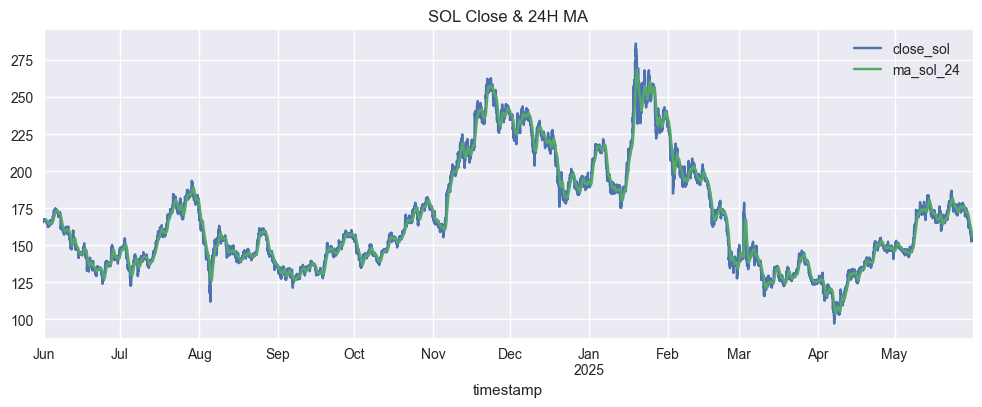

In [4]:
df["close_sol"] = df["Close"].astype(float)
df["ma_sol_24"] = df["close_sol"].rolling(24).mean()

df.set_index("timestamp")[["close_sol", "ma_sol_24"]].plot(figsize=(12,4), title="SOL Close & 24H MA")
plt.show()

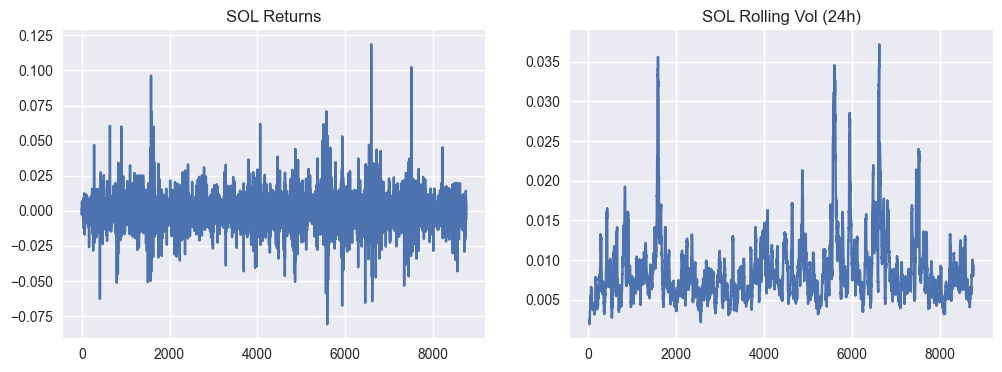

In [5]:
df["ret_sol"] = df["close_sol"].pct_change()
df["ret_btc"] = df["close_BTC_1h"].astype(float).pct_change()
df["ret_eth"] = df["close_ETH_4h"].astype(float).pct_change()

df["vol_sol_24h"] = df["ret_sol"].rolling(24).std()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["ret_sol"].plot(ax=axes[0], title="SOL Returns")
df["vol_sol_24h"].plot(ax=axes[1], title="SOL Rolling Vol (24h)")
plt.show()

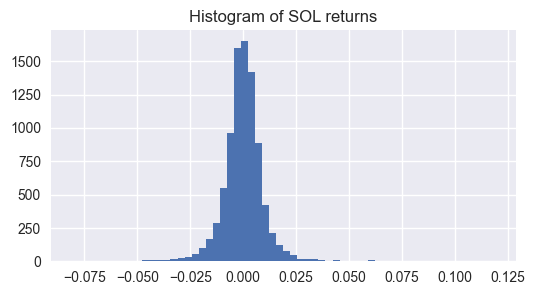

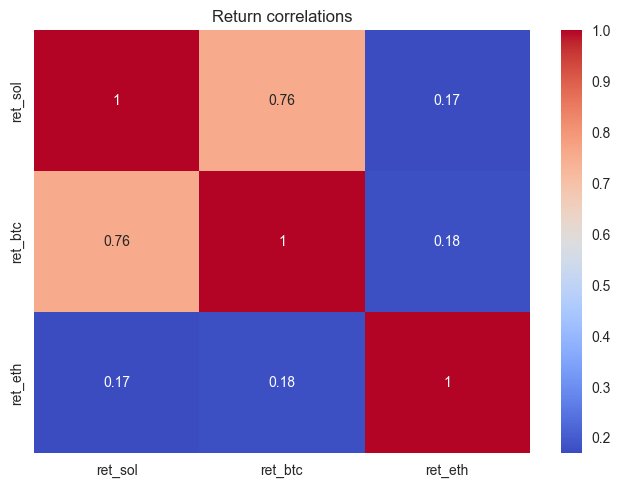

In [6]:
df["ret_sol"].hist(bins=60, figsize=(6,3))
plt.title("Histogram of SOL returns")
plt.show()

corr = df[["ret_sol","ret_btc","ret_eth"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Return correlations")
plt.show()

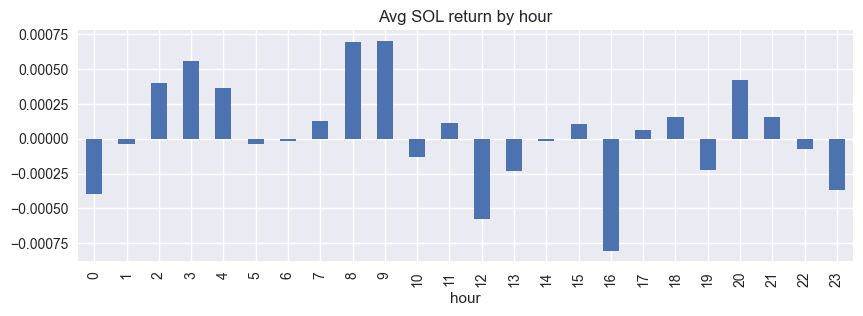

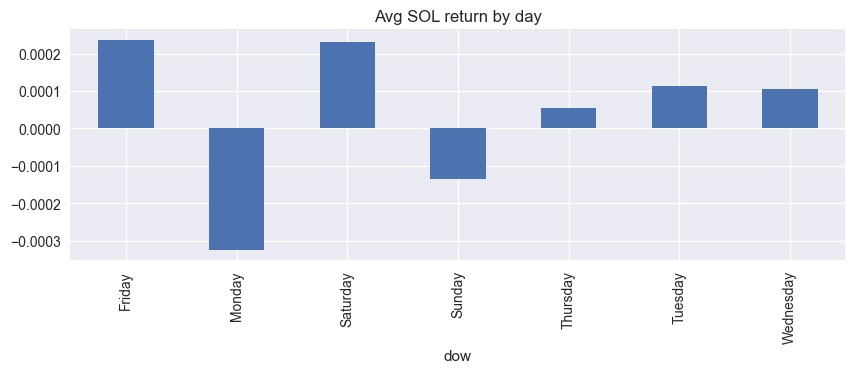

In [7]:
df["hour"] = df["timestamp"].dt.hour
df["dow"]  = df["timestamp"].dt.day_name()

df.groupby("hour")["ret_sol"].mean().plot(kind="bar", figsize=(10,3), title="Avg SOL return by hour")
plt.show()

df.groupby("dow")["ret_sol"].mean().plot(kind="bar", figsize=(10,3), title="Avg SOL return by day")
plt.show()

In [8]:
df["sol_ma_fast"] = df["close_sol"].rolling(12).mean()
df["sol_ma_slow"] = df["close_sol"].rolling(48).mean()
df["sol_ma_diff"] = (df["sol_ma_fast"] - df["sol_ma_slow"]) / (df["sol_ma_slow"] + 1e-12)

spread = df["ret_sol"] - 0.5*(df["ret_btc"] + df["ret_eth"])
df["spread_z"] = (spread - spread.rolling(48).mean()) / (spread.rolling(48).std() + 1e-12)
df["spread_z_lag1"] = df["spread_z"].shift(1)

In [9]:
def classify(row, z_buy=0.5, z_sell=-0.5):
    if row["spread_z_lag1"] > z_buy:
        return "BUY"
    elif row["spread_z_lag1"] < z_sell:
        return "SELL"
    return "HOLD"

df["signal"] = df.apply(classify, axis=1)
df["position_size"] = np.clip(np.abs(df["spread_z_lag1"]) / 2.0, 0, 1)

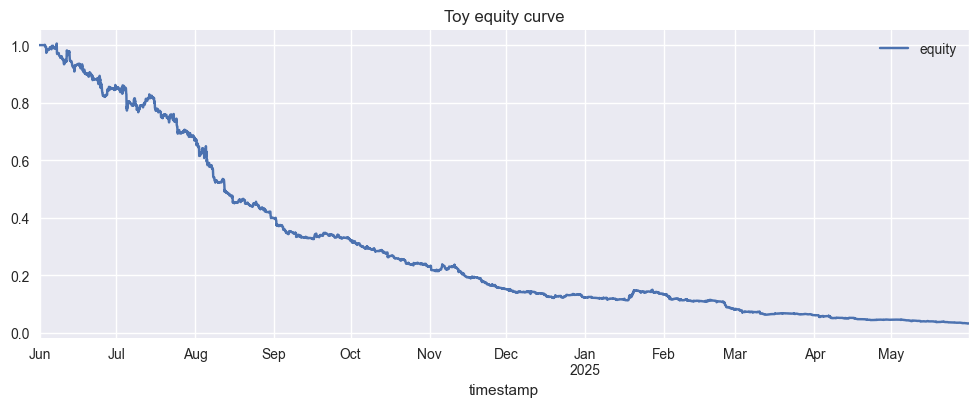

Sharpe: -0.38, MaxDD: -96.73%, Final equity: 0.03


In [10]:
side = df["signal"].map({"BUY": 1, "SELL": -1, "HOLD": 0})
df["strat_ret"] = side.shift(1) * df["ret_sol"] * df["position_size"].shift(1)
df["equity"] = (1 + df["strat_ret"].fillna(0)).cumprod()

df.set_index("timestamp")[["equity"]].plot(figsize=(12,4), title="Toy equity curve")
plt.show()

ret = df["strat_ret"].dropna()
sharpe = np.sqrt(24) * ret.mean() / (ret.std() + 1e-12)
drawdown = (df["equity"] / df["equity"].cummax() - 1).min()

print(f"Sharpe: {sharpe:.2f}, MaxDD: {drawdown:.2%}, Final equity: {df['equity'].iloc[-1]:.2f}")

In [11]:
out = pd.DataFrame({
    "timestamp": df["timestamp"],
    "symbol": "SOL",
    "signal": df["signal"],
    "position_size": df["position_size"]
})

out.to_csv("../results/sample_signals.csv", index=False)
out.head()

,timestamp,symbol,signal,position_size
0,2024-05-31 19:00:00+00:00,SOL,HOLD,NaN
1,2024-05-31 20:00:00+00:00,SOL,HOLD,NaN
2,2024-05-31 21:00:00+00:00,SOL,HOLD,NaN
3,2024-05-31 22:00:00+00:00,SOL,HOLD,NaN
4,2024-05-31 23:00:00+00:00,SOL,HOLD,NaN
